### Can You Beat the Casino With Math? We Simulated a Famous Roulette Strategy to Find Out.

Have you ever heard of a "guaranteed" way to win at the casino? A while back, a family member excitedly told me about a betting strategy for roulette that sounded foolproof. The logic was so simple, so compelling, that it seemed like a mathematical certainty.

The strategy is called the **Martingale**, and it works like this:

1.  You bet a small amount, say \$1, on Red.
2.  If you win, great! You pocket the \$1 profit and bet a dollar on Red again.
3.  If you lose, you simply **double your previous bet**.
4.  You keep doubling after every loss until you eventually win. That single win will recover all your previous losses *plus* give you a \$1 profit.

It seems like you can't lose, right? No matter how long your losing streak is, one win brings you back into the black. But as data scientists, we know that things that seem too good to be true often are. So, I decided to put it to the test using a computer simulation.

#### Building Our Digital Casino

To see if this strategy holds up in the real world, we need to account for real-world rules. We can't just play with infinite money and time. So, I programmed a simulation with the following parameters for our digital gambler:

*   **Starting Budget (B):** You walk into the casino with **\$200**.
*   **Winnings Goal (W):** You'll walk away a winner if you reach **\$300** (a \$100 profit).
*   **Time Limit (L):** You'll only play for a maximum of **200 spins**.
*   **Max Wager (M):** The casino has a table limit of **\$100** for a single bet.

The game is American Roulette, where the wheel has 18 red, 18 black, and 2 green pockets. This means the probability of winning a bet on Red is 18/38, or about 47.4%.

#### A Few Trips to the Roulette Table

First, let's see what a few individual visits to our digital casino might look like. I ran the simulation five times to chart the gambler's journey.

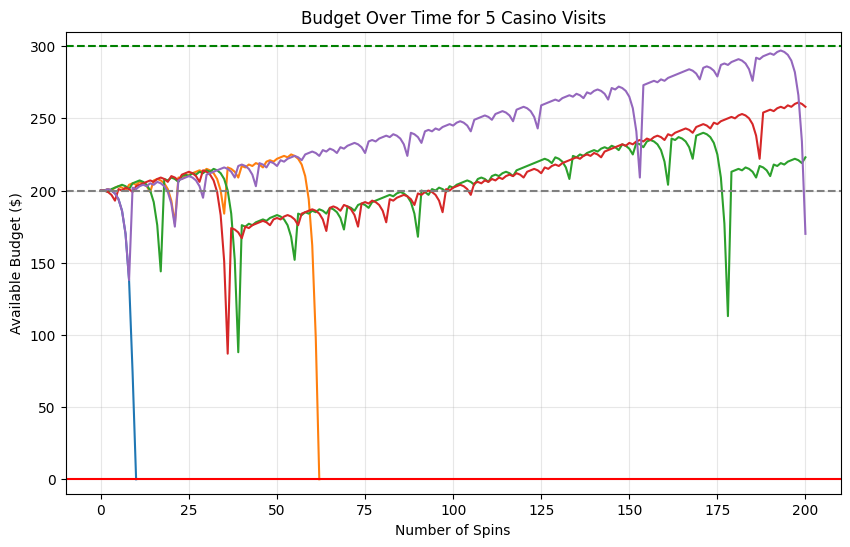

The average profit was $-36.35.


In [3]:
import numpy as np
from itertools import groupby
import matplotlib.pyplot as plt
import pandas as pd

def oneplay(B=200, W=300, L=200, M=100, summary=True):

    def wager(ledger, M):
        if ledger["outcome"][-1] == 1:
            new_wager = 1
        else:
            new_wager = 2 * ledger["wager"][-1]
        
        new_wager = min(new_wager, M, ledger["budget"][-1])
        ledger["wager"].append(new_wager)

    def spin(ledger):
        spin_result = np.random.binomial(1, p=18/38)
        ledger["outcome"].append(spin_result)

    def stop_rule(ledger, W, L):
        if ledger["outcome"][-1] == 1: 
            ledger["budget"].append(ledger["budget"][-1] + ledger["wager"][-1])
        else:
            ledger["budget"].append(ledger["budget"][-1] - ledger["wager"][-1])

        if ledger["budget"][-1] >= W:
            return 1 
        elif len(ledger["budget"]) - 1 >= L:
            return -1 
        elif ledger["budget"][-1] <= 0:
            return -2 
        else:
            return 0 

    ledger = {"budget": [B, B], "wager": [0], "outcome": [1]}
    outcome = 0
    while outcome == 0:
        wager(ledger, M)
        spin(ledger)
        outcome = stop_rule(ledger, W, L)

    if not summary:
        return ledger

    streaks = [len(list(values)) for key, values in groupby(ledger["outcome"]) if key == 0]
    bad_luck = max(streaks, default=0)

    summary_data = {
        "B": B, "W": W, "L": L, "M": M,
        "outcome": outcome,
        "profit": ledger["budget"][-1] - B,
        "n_games": len(ledger["budget"]) - 1,
        "prop_red": np.mean(ledger["outcome"][1:]),
        "bad_luck_streak": bad_luck
    }
    return summary_data

# graph
plt.figure(figsize=(10, 6))
for i in range(5):
    play_data = oneplay(summary=False)
    plt.plot(play_data["budget"], label=f'Visit {i+1}')

plt.title("Budget Over Time for 5 Casino Visits")
plt.xlabel("Number of Spins")
plt.ylabel("Available Budget ($)")
plt.axhline(y=200, color='grey', linestyle='--', label='Starting Budget')
plt.axhline(y=300, color='green', linestyle='--', label='Winning Goal')
plt.axhline(y=0, color='red', linestyle='-', label='Bankruptcy')
plt.ylim(-10, 310)
plt.grid(True, alpha=0.3)
plt.show()

# simulation
R = 10000
simulations = [oneplay() for i in range(R)]
df = pd.DataFrame(simulations)
average_profit = df['profit'].mean()
print(f"The average profit was ${average_profit:.2f}.")

As you can see, the results are all over the place. Two of the simulations ended in complete bankruptcy! The gambler's budget plummeted to zero. Two other players won some money but had to stop before reaching their three-hundred dollar goal because they ran out of time. 
This visualization shows the strategy's volatility. While you're slowly gaining one-dollar at a time, a string of bad luck can wipe you out in an instant.

#### The Big Picture: What Happens Over 10,000 Visits?

To truly understand if the strategy is profitable, we need to look at the average result over thousands of visits. Does the occasional big win make up for the frequent, catastrophic losses? I ran the simulation **10,000 times**.

The average profit was **-\$36.35**.

That’s right. On average, you don't break even; you lose nearly $36 every time you walk into the casino with this "guaranteed" strategy.

#### What If We Change the Goal?

Maybe a one-hundred dollar profit is too greedy. What if we set a more modest goal, like just trying to win twenty-five dollars? Or what if we're more ambitious and aim for one-hundred-fifty dollars? Does our winning threshold change the outcome?

Let's run the simulation again, this time calculating the average profit for several different winning thresholds.

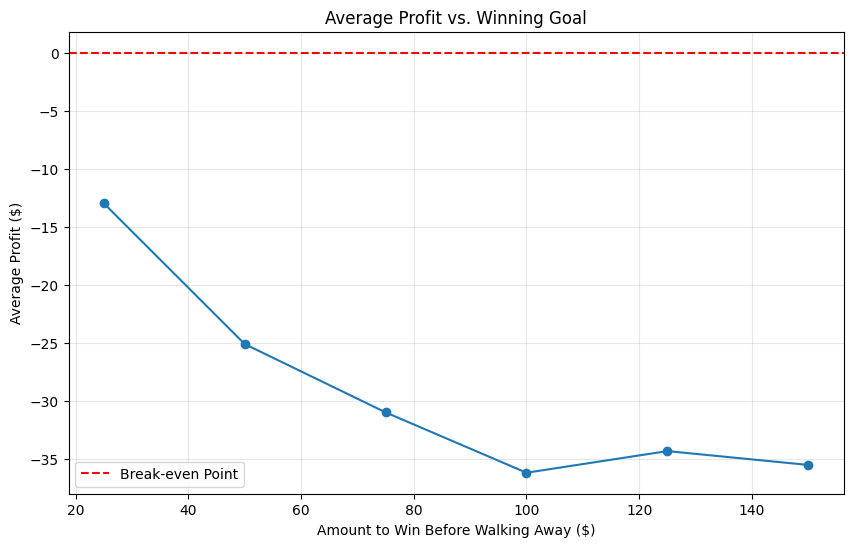

   walk_away_rule   profit
0              25 -12.9614
1              50 -25.0806
2              75 -30.9634
3             100 -36.1601
4             125 -34.2983
5             150 -35.4905


In [2]:
R = 10000
winning_goals = [25, 50, 75, 100, 125, 150]
results = []

for goal in winning_goals:
    simulations = [oneplay(W = 200 + goal) for i in range(R)]
    df = pd.DataFrame(simulations)
    avg_profit = df['profit'].mean()
    results.append({'walk_away_rule': goal, 'profit': avg_profit})

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['walk_away_rule'], results_df['profit'], marker='o')
plt.title("Average Profit vs. Winning Goal")
plt.xlabel("Amount to Win Before Walking Away ($)")
plt.ylabel("Average Profit ($)")
plt.axhline(y=0, color='red', linestyle='--', label='Break-even Point')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(results_df)

The message from this chart is crystal clear. No matter what your winning goal is, the average profit is **always negative**. 
While being less greedy (aiming for twenty-five dollars) results in a smaller average loss than being more greedy (aiming for one-hundred-and-fifty dollars), you never cross into profitable territory.

#### The Take-Home Message: Is the Strategy Profitable?

**No. The Martingale strategy is not profitable.** In the long run, it is a mathematical certainty that you will lose money.

The seductive logic of "one win recovers everything" tragically ignores two things:
1.  **You don't have infinite money.** A long losing streak (and they happen more often than you think) will force your bets to grow exponentially, leading you straight to bankruptcy.
2.  **Casinos have betting limits.** Even if you had a massive bankroll, you'd eventually hit the table's max bet, breaking the "doubling" rule and locking in your massive losses.

The two green pockets on the wheel give the house a permanent edge that no betting strategy can overcome. So, the next time someone tells you they have a foolproof system to beat the casino, you can tell them you’ve seen the simulation, and the house always wins.